## Installing packages

In [1]:
!pip install -q timm pycocotools

## Importing ibraries

In [2]:
import os
import pandas as pd
import numpy as np
import warnings
import random

import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image

import torch
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2 as T_v2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import timm
from pprint import pprint
from tqdm import tqdm
from typing import List, Dict
from dataclasses import dataclass
from functools import partial

# from transformers import AutoImageProcessor, AutoModelForObjectDetection
from transformers import(
    DetrImageProcessor,
    DetrModel,
    DetrConfig,
    DetrFeatureExtractor,
    DetrForObjectDetection,
    ConditionalDetrForObjectDetection,
    ConditionalDetrConfig

)

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from transformers.image_transforms import center_to_corners_format
from transformers import HfArgumentParser,Trainer,TrainingArguments

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
warnings.filterwarnings("ignore")

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

In [5]:
## reproducability
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

## Loading data

In [6]:
train_ds = pd.read_csv('/kaggle/input/muzzle-nomuzzle/dataset1/train.csv')
val_ds = pd.read_csv('/kaggle/input/muzzle-nomuzzle/dataset1/valid.csv')
test_ds = pd.read_csv('/kaggle/input/muzzle-nomuzzle/dataset1/test.csv')

In [7]:
train_ds.head(2)

filename  width  height   class  \
0  reg_573201-563-2_20231219101115644_121_jpg.rf....    640     640  Muzzle   
1  reg_573201-854-2_20231216091251748_61_jpg.rf.b...    640     640  Muzzle   

   xmin  ymin  xmax  ymax  
0    57   142   521   442  
1   144   270   466   496

In [8]:
test_ds.tail(2)

filename  width  height  \
139  16-1-_jpg.rf.d6b0e1a644a2f94cee5ff9aa9ae93283.jpg    640     640   
140     42_jpg.rf.fd8d42c9456902c39f7715ae56c477b9.jpg    640     640   

         class  xmin  ymin  xmax  ymax  
139  No-Muzzle   108    11   578   402  
140  No-Muzzle    60    15   552   382

In [9]:
val_ds.head(3)

filename  width  height   class  \
0  reg_573201-607-2_20231209134253363_141_jpg.rf....    640     640  Muzzle   
1  reg_573201-779-1_20231215090158889_130_jpg.rf....    640     640  Muzzle   
2  reg_573201-608-2_20231207125712532_1_jpg.rf.01...    640     640  Muzzle   

   xmin  ymin  xmax  ymax  
0   191   261   436   448  
1   129   261   428   407  
2   192   157   520   423

The data has one class and the bounding boxes is in Pascal Format(xmin,ymin,xmax,ymax)

In [10]:
print(f"len of training data: {len(train_ds)}")
print(f"len of val data: {len(val_ds)}")
print(f"len of test data: {len(test_ds)}")

len of training data: 1799
len of val data: 287
len of test data: 141


In [11]:
def prepare_datasets(train_df, train_img_dir, 
                                          val_df, val_img_dir, 
                                          test_df, test_img_dir):
    def add_image_path_and_shuffle(df, img_dir):
        df['image_path'] = img_dir + '/' + df['filename']
        return df.sample(frac=1).reset_index(drop=True)

    train_df = add_image_path_and_shuffle(train_df, train_img_dir)
    val_df = add_image_path_and_shuffle(val_df, val_img_dir)
    test_df = add_image_path_and_shuffle(test_df, test_img_dir)

    return train_df, val_df, test_df

In [12]:
train_dir = '/kaggle/input/muzzle-nomuzzle/dataset1/train'
val_dir='/kaggle/input/muzzle-nomuzzle/dataset1/valid'
test_dir='/kaggle/input/muzzle-nomuzzle/dataset1/test'

train_df, val_df, test_df = prepare_datasets(
    train_ds, train_dir,
    val_ds,val_dir,
    test_ds, test_dir
)

In [13]:
train_df.head(2)

filename  width  height   class  \
0  reg_573201-663-2_20231206093857411_91_jpg.rf.4...    640     640  Muzzle   
1    O_1_jpg.rf.cf926d6264ef79124f6099515d01bfe7.jpg    640     640  Muzzle   

   xmin  ymin  xmax  ymax                                         image_path  
0   179   238   469   444  /kaggle/input/muzzle-nomuzzle/dataset1/train/r...  
1   246   352   386   438  /kaggle/input/muzzle-nomuzzle/dataset1/train/O...

## EDA

In [ ]:
img_path_train = train_df.image_path[20]
img_path_test = test_df.image_path[100]
img_path_val = val_df.image_path[220]

# Load the images
img_train = mpimg.imread(img_path_train)
img_test = mpimg.imread(img_path_test)
img_val = mpimg.imread(img_path_val)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

titles = ['Train Image', 'Test Image', 'Validation Image']
images = [img_train, img_test, img_val]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img)
    ax.axis('off')  
    ax.set_title(title)

plt.tight_layout()
plt.show()


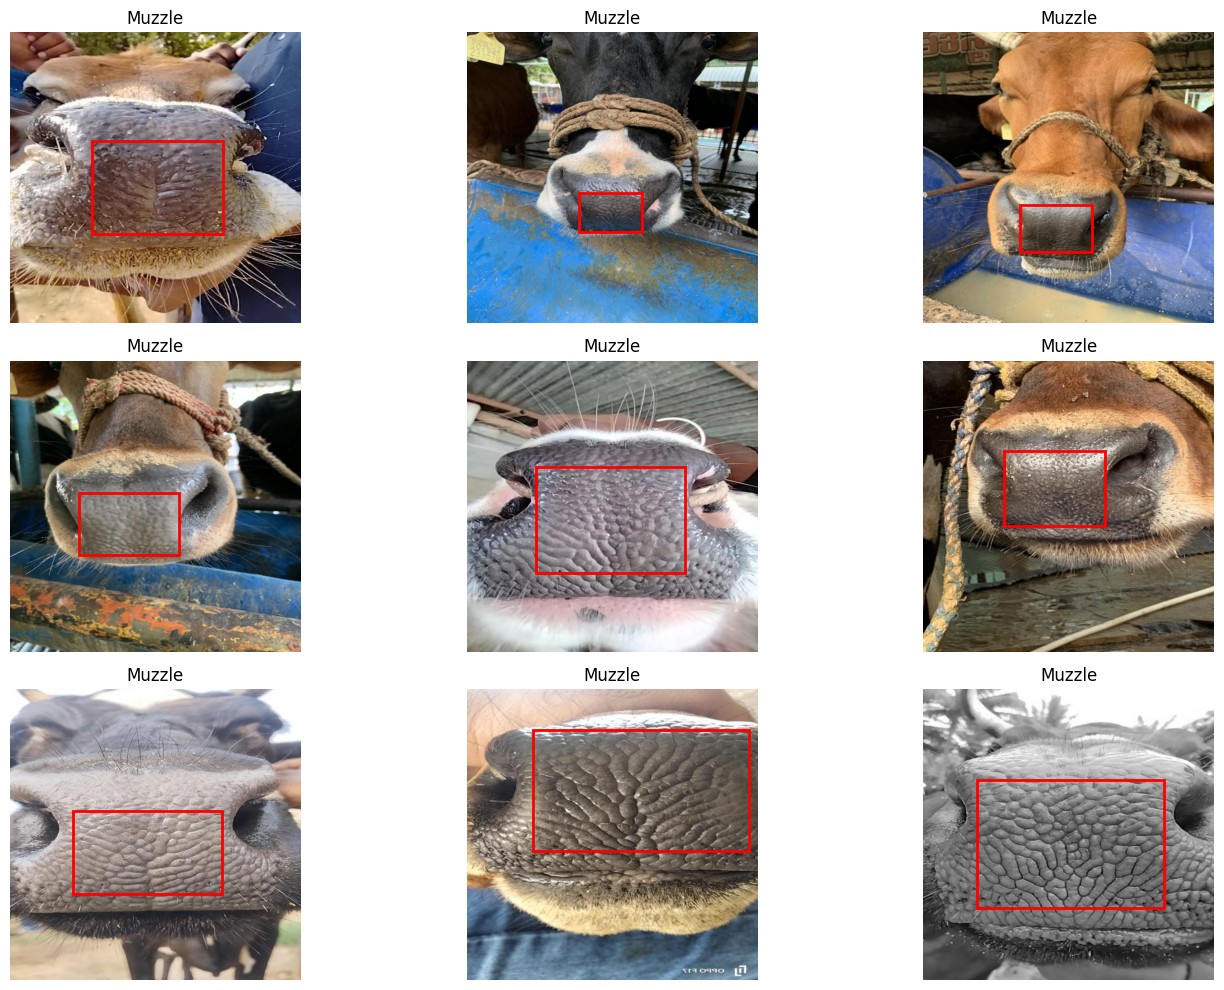

In [15]:
def display_images_with_boxes(df, num_images=9):
    num_rows = 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    for i in range(num_images):
        img_path = df.iloc[i]['image_path']
        img = plt.imread(img_path)
        ax = axes[i // num_cols, i % num_cols]  
        ax.imshow(img)
        ymin, xmin, ymax, xmax = df.iloc[i]['ymin'], df.iloc[i]['xmin'], df.iloc[i]['ymax'], df.iloc[i]['xmax']
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # ax.set_title(f"{df.iloc[i]['class']} (Image: {df.iloc[i]['Image_ID']})")
        ax.set_title(f"{df.iloc[i]['class']}")
        ax.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()



# Display the first 6 images
display_images_with_boxes(train_df, num_images=9)

In [16]:
img_pth = train_df.image_path[100]
Image.open(img_pth).size

(640, 640)

In [17]:
train_df.describe()

width  height         xmin         ymin         xmax         ymax
count  1799.0  1799.0  1799.000000  1799.000000  1799.000000  1799.000000
mean    640.0   640.0   177.176765   231.870484   463.353530   419.785992
std       0.0     0.0    75.172837    85.416687    71.871328    59.468477
min     640.0   640.0     0.000000     0.000000   131.000000   162.000000
25%     640.0   640.0   129.000000   174.000000   422.000000   380.000000
50%     640.0   640.0   165.000000   230.000000   472.000000   416.000000
75%     640.0   640.0   221.500000   291.000000   509.000000   461.000000
max     640.0   640.0   506.000000   488.000000   640.000000   640.000000

In [18]:
train_df.isnull().sum()

filename      0
width         0
height        0
class         0
xmin          0
ymin          0
xmax          0
ymax          0
image_path    0
dtype: int64

In [19]:
train_df.duplicated().sum()

0

In [20]:
train_df1=train_df.copy()

In [21]:
train_df1['bbox_area'] = (train_df1['xmax'] - train_df1['xmin']) * (train_df1['ymax'] - train_df1['ymin'])

In [22]:
train_df1.bbox_area.max()

336864

In [23]:
train_df1.bbox_area.min()

720

In [24]:
train_imgs=train_df1.image_path

In [25]:
def get_all_bboxes(df, image_id):
    # Filter the rows for the specific image_id
    image_bboxes = df[df.filename == image_id]
    bboxes = []
    for _, row in image_bboxes.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        width = xmax - xmin
        height = ymax - ymin
        
        bboxes.append((xmin, ymin, width, height))
        
    return bboxes


In [26]:
def plot_image_examples(df, rows=3, cols=3, title='Muzzle examples'):
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].filename

            img_path = [path for path in train_imgs if img_id in path][0]  
            img = Image.open(img_path)
            axs[row, col].imshow(img)
            bboxes = get_all_bboxes(df, img_id)
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
                axs[row, col].add_patch(rect)
            axs[row, col].axis('off')
    
    # Set the title for the entire figure
    plt.suptitle(title)
    plt.show()


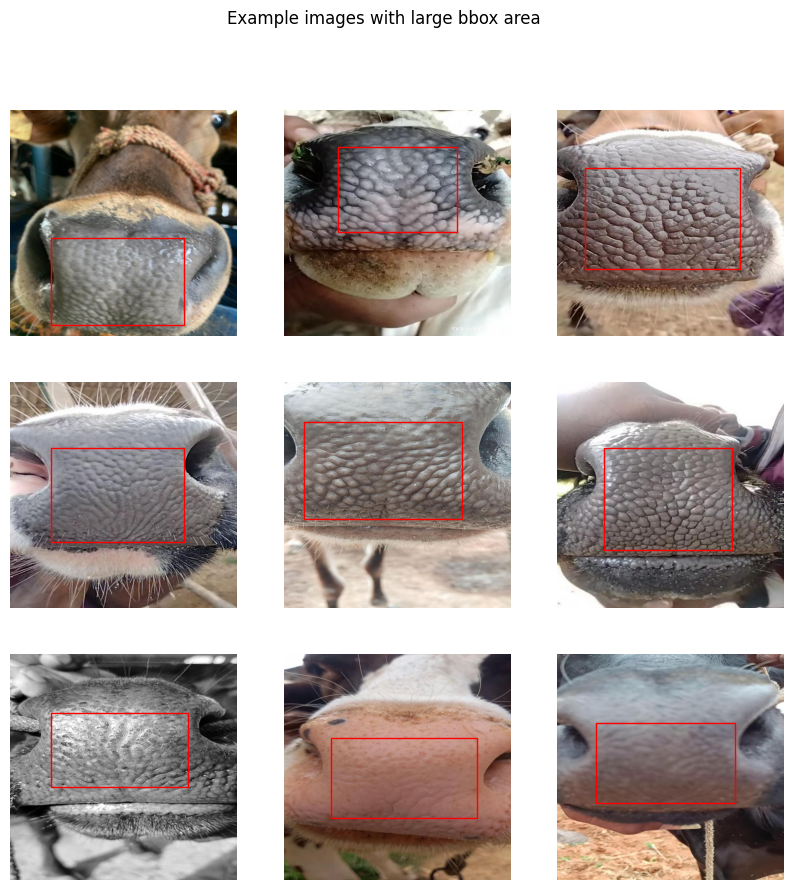

In [27]:
# view large area boxes
large_boxes_ids = train_df1[train_df1['bbox_area'] > 80000].filename
plot_image_examples(train_df1[train_df1.filename.isin(large_boxes_ids)], title='Example images with large bbox area')

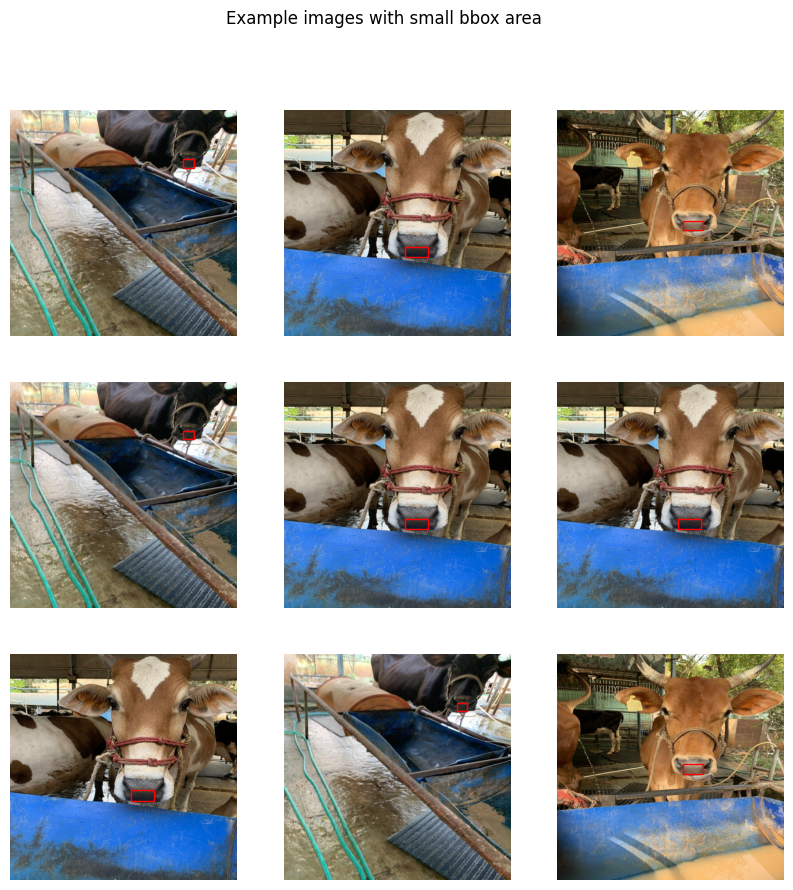

In [28]:
# view large area boxes
small_boxes_ids = train_df1[train_df1['bbox_area'] <= 2000].filename
plot_image_examples(train_df1[train_df1.filename.isin(small_boxes_ids)], title='Example images with small bbox area')

In [29]:
def get_image_brightness(image): 
    """Function to calculate the average brightness of an image."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

def add_brightness(df, image_dir):
    """Function to add a 'brightness' column to the dataframe."""
    brightness = []

    for _, row in df.iterrows():
        img_id = row['filename']
        image_path = row['image_path']
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
            brightness.append(get_image_brightness(image))
        else:
            print(f"Warning: Image {img_id}.jpg not found, setting brightness to NaN.")
            brightness.append(np.nan)  # Append NaN if image is not found
    df['brightness'] = brightness
    
    return df


In [30]:
images_df = train_df1[['filename', 'image_path']]  
brightness_df = add_brightness(images_df, train_dir)  
train_df2 = train_df1.merge(brightness_df, on='filename', how='left')

In [31]:
train_df2.brightness.max()

245.38277099609374

In [32]:
train_df2.brightness.min()

52.7933642578125

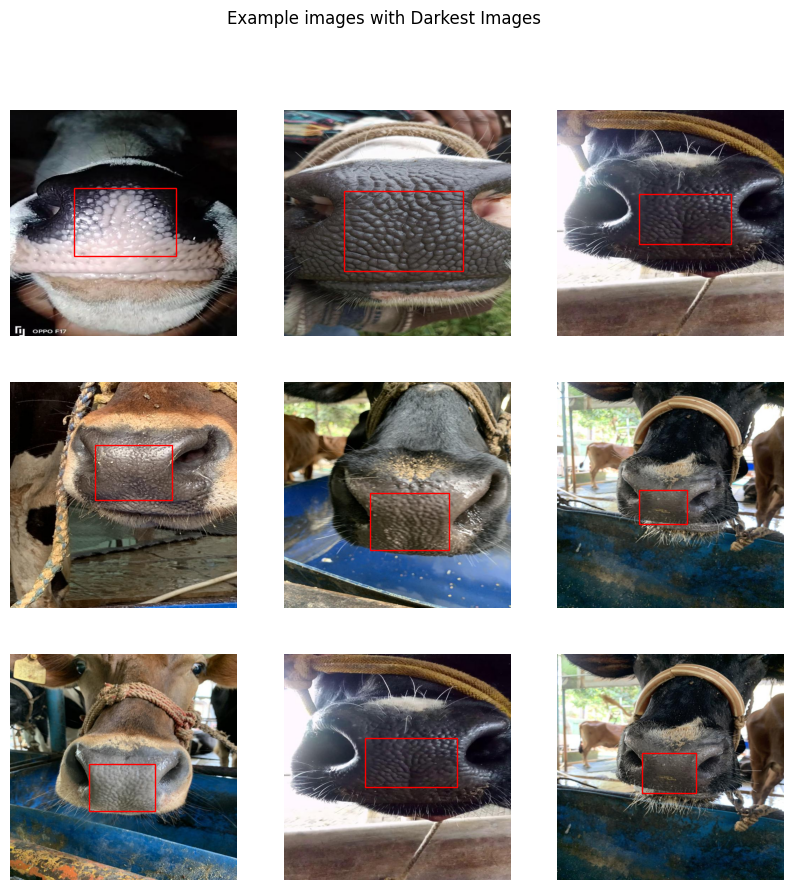

In [33]:
# view ldark imgs
dark_ids = train_df2[train_df2['brightness'] < 100].filename
plot_image_examples(train_df2[train_df2.filename.isin(dark_ids )], title='Example images with Darkest Images')

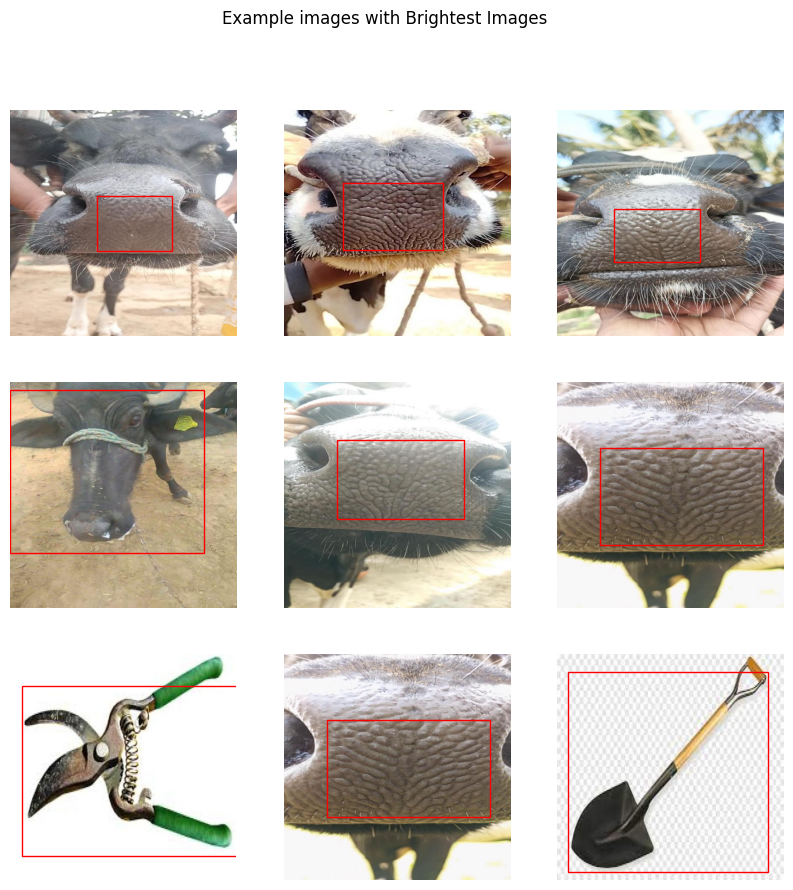

In [34]:
# view ldark imgs
bright_ids = train_df2[train_df2['brightness'] > 150].filename
plot_image_examples(train_df2[train_df2.filename.isin(bright_ids)], title='Example images with Brightest Images')

What to note from the EDA:

There is only one bounding box for a muzzle

The images are taken from different proximity

The images vary in brigtness

## Pre-processing

In [35]:
classes=train_df['class'].unique()
id2label = {index: x for index, x in enumerate(classes, start=0)}
label2id = {v: k for k, v in id2label.items()}

In [36]:
train_df['encoded_labels'] = train_df['class'].map(label2id)
val_df['encoded_labels'] = val_df['class'].map(label2id)
test_df['encoded_labels'] = test_df['class'].map(label2id)

In [37]:
MAX_SIZE = 384

feature_extractor = DetrFeatureExtractor.from_pretrained(
    # "facebook/detr-resnet-50",
    "facebook/detr-resnet-50",
    do_resize=True,
    size={"max_height": MAX_SIZE, "max_width": MAX_SIZE},
    do_rescale =False,
    do_normalize=False,
    # do_convert_annotations=True
    do_pad=True,
    pad_size={"height": MAX_SIZE, "width": MAX_SIZE}
)

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

In [38]:
train_df.head(3)

filename  width  height   class  \
0  reg_573201-663-2_20231206093857411_91_jpg.rf.4...    640     640  Muzzle   
1    O_1_jpg.rf.cf926d6264ef79124f6099515d01bfe7.jpg    640     640  Muzzle   
2   V_12_jpg.rf.71e3ed45f9e78ce754c5f1504c7bf25b.jpg    640     640  Muzzle   

   xmin  ymin  xmax  ymax                                         image_path  \
0   179   238   469   444  /kaggle/input/muzzle-nomuzzle/dataset1/train/r...   
1   246   352   386   438  /kaggle/input/muzzle-nomuzzle/dataset1/train/O...   
2   212   380   370   483  /kaggle/input/muzzle-nomuzzle/dataset1/train/V...   

   encoded_labels  
0               0  
1               0  
2               0

In [39]:
feature_extractor

DetrFeatureExtractor {
  "do_convert_annotations": true,
  "do_normalize": false,
  "do_pad": true,
  "do_rescale": false,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DetrFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "pad_size": {
    "height": 384,
    "width": 384
  },
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "max_height": 384,
    "max_width": 384
  }
}

In [40]:
class Muzzle(object):
    def __init__(self, df, transforms, feature_extractor, return_pixel_mask=False):
        self.df = df
        self.img_paths = self.df['image_path'].unique().tolist()
        self.image_ids = self.df['filename'].unique().tolist()
        self.transforms = transforms
        # self.image_processor = image_processor
        self.feature_extractor = feature_extractor
        self.return_pixel_mask = return_pixel_mask

    def __len__(self) -> int:
        self.image_ids = np.array(self.image_ids)
        return self.image_ids.shape[0]

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]  
        image_path = self.img_paths[idx]

        # Load and normalize the image
        # image = Image.open(image_path).convert('RGB')
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image, dtype=np.float32) / 255.0  # Normalize the image

        # Get bounding box values and labels for the current image
        # image_values = self.df[self.df['image_path'] == image_path]
        image_values = self.df[self.df['filename'] == image_id]
        boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        labels = image_values["encoded_labels"].values

        # Convert boxes to COCO format (x_min, y_min, width, height)
        coco_boxes = []
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            width = xmax - xmin
            height = ymax - ymin
            coco_boxes.append([xmin, ymin, width, height])

        # Compute areas for each bounding box
        area = [box[2] * box[3] for box in coco_boxes]

        # Create annotations for the image
        annotations = []
        for i, (coco_box, label) in enumerate(zip(coco_boxes, labels)):
            annotations.append({
                'bbox': list(torch.tensor(coco_box, dtype=torch.float32)),
                'category_id': torch.tensor(label, dtype=torch.int64),
                'area': torch.tensor(area[i], dtype=torch.float32),
                'iscrowd': 0
            })
        target = {
            'image_id': torch.tensor([idx]),
            'annotations': annotations
        }

        # # Handle empty annotations
        # if boxes.shape[0] == 0 or (boxes == 0).all():
        #     target['annotations'] = [
        #         {
        #             'bbox': torch.empty((0, 4), dtype=torch.float32),
        #             'category_id': torch.empty([], dtype=torch.int64),
        #             'confidence': torch.empty(1, dtype=torch.float32),
        #             'area': torch.empty([], dtype=torch.float32),  # Fixed empty area tensor
        #             'iscrowd': torch.empty([], dtype=torch.int64)
        #         }
        #     ]

        # Apply transformations
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': [ann['bbox'] for ann in annotations],
                'labels': [ann['category_id'] for ann in annotations]
            }
            sample = self.transforms(**sample)
            image = sample['image']

            # Update bounding boxes and labels after transformations
            transformed_bboxes = sample['bboxes']
            transformed_labels = sample['labels']
            annotations = []
            for i, bbox in enumerate(transformed_bboxes):
                annotations.append({
                    'bbox': bbox,
                    'category_id': transformed_labels[i],
                    'area': bbox[2] * bbox[3],
                    'iscrowd': 0
                })

            target['annotations'] = annotations

        # Process the image and target using the image_processor
        result = self.feature_extractor(images=[image], annotations=[target], return_tensors="pt")
        
        if not self.return_pixel_mask in result:
            result.pop("pixel_mask", None)
            
        result['pixel_values'] = result['pixel_values'].squeeze(0)
        result['labels'] = result['labels'][0]

        return result


In [41]:
def get_train_transform():
    return A.Compose([
        A.Resize(384, 384),  
        A.RandomBrightnessContrast(
            brightness_limit=(-0.1, 0.1),
            contrast_limit=(-0.1, 0.1),
            p=0.8
        ),
        A.HueSaturationValue(
            hue_shift_limit=0.2,
            sat_shift_limit=0.2,
            val_shift_limit=0.2,
            p=0.8
        ),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        A.Blur(blur_limit=3, p=0.1),
        A.Sharpen(p=0.1),
        ToTensorV2(p=1.0)
    ], bbox_params=A.BboxParams(format='coco', label_fields=['labels'], clip=True, min_area=25))

def get_test_transform():
    return A.Compose([
        A.Resize(384, 384),
        ToTensorV2(p=1.0)
    ], bbox_params=A.BboxParams(format='coco', label_fields=['labels'], clip=True))


In [42]:
train_transforms = get_train_transform()
test_transforms = get_test_transform()

In [43]:
# Dataset 
train_dataset = Muzzle(train_df, transforms=train_transforms, feature_extractor=feature_extractor,return_pixel_mask=False)
val_dataset = Muzzle(val_df, transforms=train_transforms,feature_extractor=feature_extractor, return_pixel_mask = False)
test_dataset = Muzzle(test_df, transforms=test_transforms,feature_extractor=feature_extractor, return_pixel_mask = False)

In [44]:
train_dataset[0]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


{'pixel_values': tensor([[[0.5529, 0.5412, 0.5216,  ..., 0.2863, 0.3098, 0.3373],
         [0.5333, 0.5216, 0.5255,  ..., 0.2863, 0.3098, 0.3333],
         [0.5137, 0.5137, 0.5098,  ..., 0.2863, 0.3059, 0.3451],
         ...,
         [0.6039, 0.1373, 0.1961,  ..., 0.0980, 0.0863, 0.0902],
         [0.1961, 0.1922, 0.2431,  ..., 0.0980, 0.0902, 0.0902],
         [0.2588, 0.1686, 0.2941,  ..., 0.1216, 0.1255, 0.1137]],

        [[0.3451, 0.3373, 0.3529,  ..., 0.3961, 0.4039, 0.4314],
         [0.3686, 0.3451, 0.3294,  ..., 0.3961, 0.4157, 0.4275],
         [0.3255, 0.3294, 0.3333,  ..., 0.4000, 0.4157, 0.4392],
         ...,
         [0.4863, 0.0235, 0.0706,  ..., 0.1059, 0.1098, 0.0980],
         [0.0941, 0.0902, 0.1176,  ..., 0.1333, 0.1255, 0.1255],
         [0.1373, 0.0549, 0.1686,  ..., 0.1373, 0.1412, 0.1294]],

        [[0.3059, 0.2941, 0.2941,  ..., 0.5294, 0.5373, 0.5647],
         [0.3059, 0.2941, 0.2980,  ..., 0.5294, 0.5490, 0.5647],
         [0.2706, 0.2706, 0.2706,  ..., 0

In [45]:
pixel=train_dataset[1000]['pixel_values']
pixel.shape

torch.Size([3, 384, 384])

## Function to coumpute MAP

In [46]:
def convert_bbox_yolo_to_pascal(boxes, image_size):
    if len(image_size) == 1:
        image_size = [image_size[0], image_size[0]]
    boxes = center_to_corners_format(boxes)
    height, width = image_size
    boxes = boxes * torch.tensor([[width, height, width, height]])

    return boxes


In [47]:
@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


@torch.no_grad()
def compute_metrics(evaluation_results, feature_extractor, threshold=0.0, id2label=None):
    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids
    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    # Process targets
    for batch in targets:
        batch_image_sizes = []
        for target in batch:
            orig_size = target["orig_size"]
            if len(orig_size) == 1:
                orig_size = [orig_size[0], orig_size[0]]  # Convert to (height, width)
            batch_image_sizes.append(orig_size)

            # Convert YOLO to Pascal VOC format
            boxes = torch.tensor(target["boxes"])
            boxes = convert_bbox_yolo_to_pascal(boxes, target["orig_size"])
            labels = torch.tensor(target["class_labels"])
            post_processed_targets.append({"boxes": boxes, "labels": labels})

        image_sizes.append(torch.tensor(batch_image_sizes))

    # Process predictions
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
        post_processed_output = feature_extractor.post_process_object_detection(
            output, threshold=threshold, target_sizes=target_sizes
        )
        post_processed_predictions.extend(post_processed_output)

    # Compute metrics using Mean Average Precision (mAP)
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    metric.update(post_processed_predictions, post_processed_targets)
    metrics = metric.compute()

    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")
    mar_100_per_class = metrics.pop("mar_100_per_class")
    for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f"map_{class_name}"] = class_map
        metrics[f"mar_100_{class_name}"] = class_mar
    # # Add class-specific metrics (only one class, muzzle)
    # metrics["map_muzzle"] = round(metrics.pop("map").item(), 4)
    # metrics["mar_100_muzzle"] = round(metrics.pop("mar_100").item(), 4)

    # Convert all metrics to a rounded dictionary
    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics


In [48]:
eval_compute_metrics_fn = partial(
    compute_metrics,feature_extractor=feature_extractor, id2label=id2label, threshold=0.5
)

## Model Training

In [49]:
# timm.list_models('resnet**')

In [50]:
id2label

{0: 'Muzzle', 1: 'No-Muzzle'}

In [51]:
config = DetrConfig.from_pretrained("facebook/detr-resnet-50")
# config.use_timm_backbone = True  
# config.backbone = 'resnet101'

config.id2label = id2label
config.label2id = label2id
config.num_queries = 5

model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    config=config,
    ignore_mismatched_sizes=True
)


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [52]:
configuration = model.config

In [53]:
configuration

DetrConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "facebook/detr-resnet-50",
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "DetrForObjectDetection"
  ],
  "attention_dropout": 0.0,
  "auxiliary_loss": false,
  "backbone": "resnet50",
  "backbone_config": null,
  "backbone_kwargs": {
    "in_chans": 3,
    "out_indices": [
      1,
      2,
      3,
      4
    ]
  },
  "bbox_cost": 5,
  "bbox_loss_coefficient": 5,
  "class_cost": 1,
  "classifier_dropout": 0.0,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "dice_loss_coefficient": 1,
  "dilation": false,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_coefficient": 0.1,
  "giou_cost": 2,
  "giou_loss_coefficient": 2,
  "id2label": {
    "0": "Muzzle",
    "1": "No-Muzzle"
  },
  "init_std": 0.02,
  "init_x

In [54]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [55]:
model.to(device)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [56]:
def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    if "pixel_mask" in batch[0]:
        data["pixel_mask"] = torch.stack([x["pixel_mask"] for x in batch])
    return data


In [57]:
training_args = TrainingArguments(
    output_dir="./model",
    num_train_epochs=15,
    fp16=True,
    per_device_train_batch_size=5,
    per_device_eval_batch_size = 5,
    eval_accumulation_steps = 4,
    dataloader_num_workers=4,
    logging_dir='./logs',      
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    weight_decay=1e-4,
    max_grad_norm=0.01,
    metric_for_best_model="eval_map",
    load_best_model_at_end=True,
    greater_is_better=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    report_to="none"
)


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    tokenizer=feature_extractor,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=eval_compute_metrics_fn
)

        

In [58]:
trainer.train()

TrainOutput(global_step=5400, training_loss=1.0337338030779804, metrics={'train_runtime': 1099.8227, 'train_samples_per_second': 24.536, 'train_steps_per_second': 4.91, 'total_flos': 2.9706899772727296e+18, 'train_loss': 1.0337338030779804, 'epoch': 15.0})

## Evaluation

In [59]:
evals_train=trainer.evaluate(eval_dataset=train_dataset, metric_key_prefix="train")
pprint(evals_train)

{'epoch': 15.0,
 'train_loss': 0.8045549988746643,
 'train_map': 0.365,
 'train_map_50': 0.5769,
 'train_map_75': 0.4294,
 'train_map_Muzzle': 0.6694,
 'train_map_No-Muzzle': 0.0607,
 'train_map_large': 0.3859,
 'train_map_medium': 0.5845,
 'train_map_small': 0.4658,
 'train_mar_1': 0.5363,
 'train_mar_10': 0.5421,
 'train_mar_100': 0.5421,
 'train_mar_100_Muzzle': 0.7656,
 'train_mar_100_No-Muzzle': 0.3186,
 'train_mar_large': 0.5571,
 'train_mar_medium': 0.6885,
 'train_mar_small': 0.5158,
 'train_runtime': 41.6784,
 'train_samples_per_second': 43.164,
 'train_steps_per_second': 8.638}


In [60]:
evals_val=trainer.evaluate(eval_dataset=val_dataset, metric_key_prefix="val")
pprint(evals_val)

{'epoch': 15.0,
 'val_loss': 1.037773609161377,
 'val_map': 0.3612,
 'val_map_50': 0.662,
 'val_map_75': 0.3829,
 'val_map_Muzzle': 0.6113,
 'val_map_No-Muzzle': 0.1112,
 'val_map_large': 0.3862,
 'val_map_medium': 0.567,
 'val_map_small': 0.4663,
 'val_mar_1': 0.4998,
 'val_mar_10': 0.5074,
 'val_mar_100': 0.5074,
 'val_mar_100_Muzzle': 0.6966,
 'val_mar_100_No-Muzzle': 0.3182,
 'val_mar_large': 0.5236,
 'val_mar_medium': 0.6658,
 'val_mar_small': 0.4667,
 'val_runtime': 7.3966,
 'val_samples_per_second': 38.802,
 'val_steps_per_second': 7.841}


In [61]:
evals_test = trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")
pprint(evals_test)

{'epoch': 15.0,
 'test_loss': 0.8677505254745483,
 'test_map': 0.4122,
 'test_map_50': 0.7626,
 'test_map_75': 0.4665,
 'test_map_Muzzle': 0.5944,
 'test_map_No-Muzzle': 0.2299,
 'test_map_large': 0.4458,
 'test_map_medium': 0.5464,
 'test_map_small': 0.0,
 'test_mar_1': 0.601,
 'test_mar_10': 0.6129,
 'test_mar_100': 0.6129,
 'test_mar_100_Muzzle': 0.6924,
 'test_mar_100_No-Muzzle': 0.5333,
 'test_mar_large': 0.6374,
 'test_mar_medium': 0.6475,
 'test_mar_small': 0.0,
 'test_runtime': 3.8241,
 'test_samples_per_second': 36.871,
 'test_steps_per_second': 7.583}


In [62]:
model.save_pretrained('./model')
feature_extractor.save_pretrained('./model')

['./model/preprocessor_config.json']

## Inference

In [77]:
#img1= '/kaggle/input/examples-3/acre examples/temp_image_file149721580268006078.png'
img2 = '/kaggle/input/examples/muzzle_1.jpg'
img1= '/kaggle/input/examples-3/acre examples/temp_image_file3047435357123243208.png'

In [64]:
model_repo = "/kaggle/working/model"

# feature_extractor = DetrFeatureExtractor.from_pretrained(model_repo)
model = DetrForObjectDetection.from_pretrained(model_repo)
model = model.to(device)

### First Image

In [78]:
x = img1
image = cv2.imread(x, cv2.IMREAD_COLOR)
image =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.array(image, dtype=np.float32) / 255.0 
x2=Image.open(x)

with torch.no_grad():
    inputs = feature_extractor(images=[image], return_tensors="pt")
    outputs = model(**inputs.to(device))
    image_size = x2.size  
    target_sizes = torch.tensor([[image_size[1], image_size[0]]])
    results = feature_extractor.post_process_object_detection(outputs, threshold=0.8, target_sizes=target_sizes)
    results =results[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected Muzzle with confidence 0.928 at location [1922.9, 653.19, 3055.19, 1031.91]


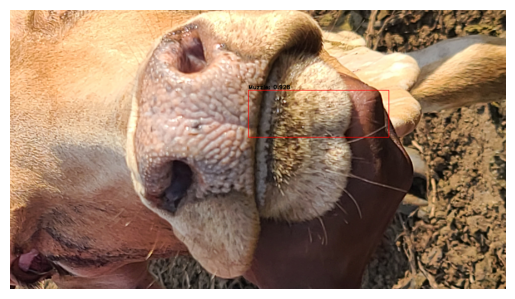

In [79]:
from PIL import Image, ImageDraw, ImageFont

image_pil = Image.open(img1)
draw = ImageDraw.Draw(image_pil)


image = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 3) 
    label_text = f"{model.config.id2label[label.item()]}: {round(score.item(), 3)}"
    cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_DUPLEX,1.5, (0, 0, 0), 3)  # Black, bold text

image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.imshow(image_pil)
plt.axis('off')  # Hide axes
plt.show()


In [72]:
y = img2
image = cv2.imread(y, cv2.IMREAD_COLOR)
image =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.array(image, dtype=np.float32) / 255.0 
y2=Image.open(y)

with torch.no_grad():
    inputs = feature_extractor(images=[image], return_tensors="pt")
    outputs = model(**inputs.to(device))
    image_size = y2.size  
    target_sizes = torch.tensor([[image_size[1], image_size[0]]])
    results = feature_extractor.post_process_object_detection(outputs, threshold=0.8, target_sizes=target_sizes)
    results =results[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected Muzzle with confidence 0.969 at location [84.15, 33.78, 129.59, 66.7]


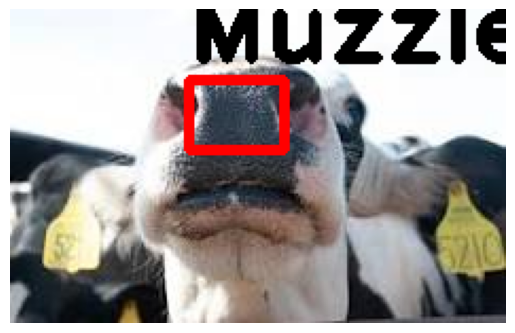

In [73]:
from PIL import Image, ImageDraw, ImageFont

image_pil = Image.open(img2)
draw = ImageDraw.Draw(image_pil)


image = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 3) 
    label_text = f"{model.config.id2label[label.item()]}: {round(score.item(), 3)}"
    cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_DUPLEX,1.5, (0, 0, 0), 3)  # Black, bold text

image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.imshow(image_pil)
plt.axis('off')  # Hide axes
plt.show()


In [80]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/checkpoint-2160/ (stored 0%)
  adding: model/checkpoint-2160/scheduler.pt (deflated 56%)
  adding: model/checkpoint-2160/rng_state.pth (deflated 25%)
  adding: model/checkpoint-2160/preprocessor_config.json (deflated 50%)
  adding: model/checkpoint-2160/model.safetensors (deflated 7%)
  adding: model/checkpoint-2160/config.json (deflated 60%)
  adding: model/checkpoint-2160/trainer_state.json (deflated 77%)
  adding: model/checkpoint-2160/optimizer.pt (deflated 19%)
  adding: model/checkpoint-2160/training_args.bin (deflated 51%)
  adding: model/checkpoint-720/ (stored 0%)
  adding: model/checkpoint-720/scheduler.pt (deflated 55%)
  adding: model/checkpoint-720/rng_state.pth (deflated 25%)
  adding: model/checkpoint-720/preprocessor_config.json (deflated 50%)
  adding: model/checkpoint-720/model.safetensors (deflated 7%)
  adding: model/checkpoint-720/config.json (deflated 60%)
  adding: model/checkpoint-720/trainer_state.json (deflated 68%)

In [82]:
from IPython.display import FileLink

FileLink(r'model.zip')


/kaggle/working/model.zip